## Import Statements

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

## Device Configuration

In [12]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device : {device}")

Device : cuda


## Data Prep

Step 1 : Download Cifar-10 Training Data  
Step 2 : Define augmentation  
Step 3 : Split the training data into train-set and validation-set in the ratio of 0.8 : 0.2  

In [13]:
# batch size for training
batch_size = 20

# Define data transformations with augmentation
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(10),  # Rotate image at an arbitrary angle (-10 to +10 degrees)
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Crop and resize from the center
    transforms.RandomHorizontalFlip(),  # Flip image horizontally (mirror image)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create augmented training dataset
augmented_train_data = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=augmentation_transform)

# Define the size of the validation dataset (20% of the total dataset)
augmented_validation_size = int(0.2 * len(augmented_train_data))
augmented_training_size = len(augmented_train_data) - augmented_validation_size

# Split the dataset into training and validation sets
augmented_training_set, augmented_validation_set = random_split(augmented_train_data, [augmented_training_size, augmented_validation_size])

augmented_train_loader = DataLoader(augmented_training_set, batch_size=batch_size, shuffle=True, num_workers=2)
augmented_valid_loader = DataLoader(augmented_validation_set, batch_size=batch_size, shuffle=False, num_workers=2)
# 10 classes in total
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## Test Set

In [14]:
# load test data (note that the data has been transformed already)
test_images = torch.load('./test_image.pt')

## Take a look at your image data

torch.Size([20, 3, 32, 32]) tensor([6, 1, 6, 1, 2, 2, 0, 9, 5, 8, 9, 6, 1, 0, 1, 4, 8, 8, 5, 0])


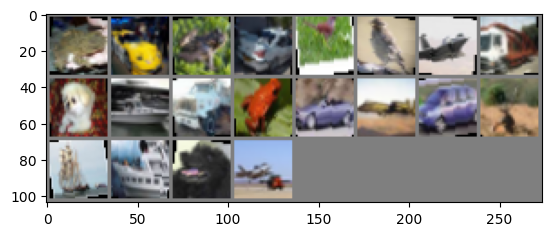

frog  car   frog  car   bird  bird  plane truck dog   ship  truck frog  car   plane car   deer  ship  ship  dog   plane


In [15]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get a random batch of training images
dataiter = iter(augmented_train_loader)
images, labels = next(dataiter)

print(images.shape, labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## CNN model


In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 10)  # 10 classes for CIFAR-10
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = CNN()

## Optimizer and Loss Function

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Training Loop

In [19]:
train_losses = []  # Store training losses
val_losses = []  # Store validation losses

model.to(device)

total_epoch = 50
for epoch in range(total_epoch):
    train_loss = 0.0
    valid_loss = 0.0

    # train the model
    model.train()
    for data, target in augmented_train_loader:
        # move data and target to the same device as the model
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item() * data.size(0)

    # Validate the model
    model.eval()
    for valid_data, valid_target in augmented_valid_loader:
        # move data and target to the same device as the model
        valid_data, valid_target = valid_data.to(device), valid_target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        valid_output = model(valid_data)
        # calculate the batch loss
        loss = criterion(valid_output, valid_target)
        # update average validation loss
        valid_loss += loss.item() * valid_data.size(0)

    # calculate average losses
    avg_val_loss = valid_loss / len(augmented_valid_loader.dataset)
    avg_train_loss = train_loss / len(augmented_train_loader.dataset)

    val_losses.append(avg_val_loss)
    train_losses.append(avg_train_loss)

    # print training/validation statistics
    print(f'Epoch: {epoch+1} / {total_epoch} \tTraining Loss: {avg_train_loss:.6f} \tValidation Loss: {avg_val_loss:.6f}')

print('Finished Training')

Epoch: 1 / 50 	Training Loss: 0.981166 	Validation Loss: 0.935794
Epoch: 2 / 50 	Training Loss: 0.862892 	Validation Loss: 0.898618
Epoch: 3 / 50 	Training Loss: 0.780917 	Validation Loss: 0.805699
Epoch: 4 / 50 	Training Loss: 0.719203 	Validation Loss: 0.670845
Epoch: 5 / 50 	Training Loss: 0.675657 	Validation Loss: 0.646051
Epoch: 6 / 50 	Training Loss: 0.630090 	Validation Loss: 0.646632
Epoch: 7 / 50 	Training Loss: 0.596263 	Validation Loss: 0.808457
Epoch: 8 / 50 	Training Loss: 0.565730 	Validation Loss: 0.581113
Epoch: 9 / 50 	Training Loss: 0.533422 	Validation Loss: 0.566929
Epoch: 10 / 50 	Training Loss: 0.514158 	Validation Loss: 0.551260
Epoch: 11 / 50 	Training Loss: 0.490234 	Validation Loss: 0.576878
Epoch: 12 / 50 	Training Loss: 0.474724 	Validation Loss: 0.549597
Epoch: 13 / 50 	Training Loss: 0.459763 	Validation Loss: 0.511275
Epoch: 14 / 50 	Training Loss: 0.435898 	Validation Loss: 0.493307
Epoch: 15 / 50 	Training Loss: 0.422615 	Validation Loss: 0.536882
Epoc

## Plot Training and Validation Los Curves

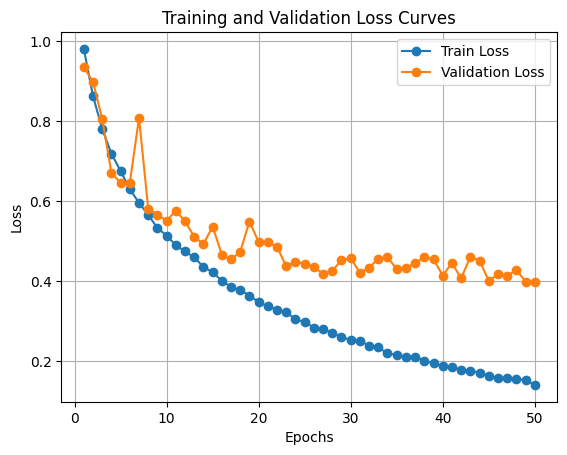

In [20]:
import matplotlib.pyplot as plt
# Plot the training and validation loss curve
plt.plot(range(1, total_epoch + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, total_epoch + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

## Make prediction on test images

['cat' 'dog' 'frog' ... 'plane' 'dog' 'bird']


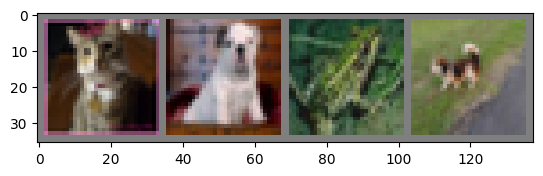

,label
0,cat
1,dog
2,frog
3,cat
4,truck
...,...
4995,horse
4996,ship
4997,plane
4998,dog


In [21]:
# since now we're testing (not training), we set no_grad to NOT calculate the gradients
with torch.no_grad():
    test_images = test_images.to(device)
    # calculate outputs by running images through the network
    outputs = model(test_images)
    # the class with the highest probability is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    predicted = np.array([classes[i] for i in predicted])

print(predicted)
# show images
imshow(torchvision.utils.make_grid(test_images[:4]))

submission = pd.DataFrame()
submission['label'] = predicted
submission.to_csv("BatchNorm_val_aug.csv", index=True, index_label='id')
submission